# Final model prediction on test set

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [4]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [5]:
# list(PATH.iterdir())

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Data augmentation

In [7]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Dataset

In [8]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [9]:
test_path = PATH/"test-315"

In [10]:
test_files = get_files(test_path)

In [11]:
paths = [d for d in list(test_path.iterdir()) if d.is_dir()]

In [12]:
labels = [p.parts[-1] for p in paths]

In [13]:
label2ind = {v:k for k,v in enumerate(labels)}

In [14]:
label2ind

{'hot_dog': 0,
 'pulled_pork_sandwich': 1,
 'grilled_cheese_sandwich': 2,
 'lobster_roll_sandwich': 3,
 'hamburger': 4,
 'club_sandwich': 5}

In [15]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [16]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

# Load final best model

In [17]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [18]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [19]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [20]:
model = ResnetV2().cuda()

In [21]:
load_model(model, model_path/"ft_resnet_85.pth")

# Without Test Time Augmentation

In [22]:
test_ds = SandwichDataset(files=test_files, labels=labels, transforms=False)

In [23]:
batch_size = 50

In [24]:
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [25]:
def test_arrays(model, test_dl):
    model.eval()
    preds = []
    ys = []
    for x, y in test_dl:
        x = x.cuda().float()
        out = model(x)
        _, pred = torch.max(out, 1)
        preds.append(pred.cpu().numpy())
        ys.append(y)
    return np.vstack(preds), np.vstack(ys)

In [26]:
preds, ys = test_arrays(model, test_dl)

In [27]:
preds = preds.reshape(-1)

In [28]:
ys = ys.reshape(-1)

In [29]:
accuracy_score(y_true=ys, y_pred=preds)

0.8613333333333333

# With Test Time Augmentation

In [30]:
test_ds_aug = SandwichDataset(files=test_files, labels=labels, transforms=True)

In [31]:
batch_size = 50

In [32]:
test_dl_aug = DataLoader(test_ds_aug, batch_size=batch_size, shuffle=False)

In [33]:
preds_aug, ys_aug = test_arrays(model, test_dl_aug)

In [34]:
preds_aug = preds_aug.reshape(-1)

In [35]:
ys_aug = ys_aug.reshape(-1)

In [36]:
accuracy_score(y_true=ys_aug, y_pred=preds_aug)

0.8753333333333333

# Confusion matrix of TTA prediction

Source code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [38]:
class_names = np.array(['hot_dog', 'pulled_pork_sandwich', 'grilled_cheese_sandwich', 
                        'lobster_roll_sandwich', 'hamburger', 'club_sandwich'])

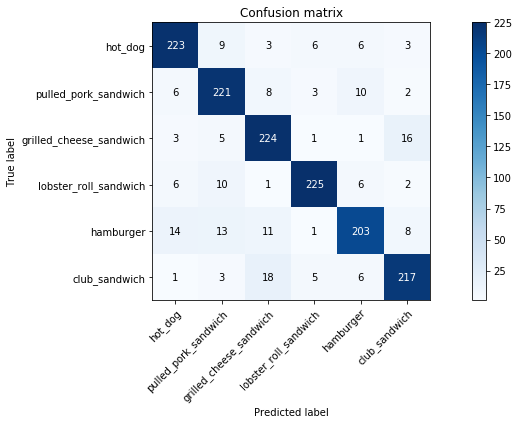

In [39]:
plt.rcParams['figure.figsize'] = [12, 6]
plot_confusion_matrix(y_true=ys_aug, y_pred=preds_aug, classes=class_names,
                      title='Confusion matrix')
plt.savefig('confusion_matrix.jpg')

# Just for fun: apply the model to photos that I took

In [40]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [41]:
actual_path = PATH/"photos"

In [42]:
new_actual_path = PATH/"photos-315"

In [43]:
new_actual_path.mkdir(exist_ok=True)

In [44]:
def resize_images(path, sz=315):
    im = read_image(path)
    sz2 = int(1.0*sz)
    return cv2.resize(im, (sz2, sz))

In [45]:
def resize_all_images(new_path, org_path, sz=300):
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (new_path/label).mkdir(exist_ok=True)
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            im = resize_images(f, sz=sz)
            cv2.imwrite(str(new_path/label/f_name), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [46]:
resize_all_images(new_actual_path, actual_path, sz=315)

In [47]:
actual_files = get_files(new_actual_path)

In [48]:
actual_paths = [d for d in list(new_actual_path.iterdir()) if d.is_dir()]

In [49]:
labels = [p.parts[-1] for p in actual_paths]

In [50]:
label2ind = {v:k for k,v in enumerate(labels)}

In [51]:
actual_ds = SandwichDataset(files=actual_files, labels=labels, transforms=True)

In [52]:
actual_dl = DataLoader(actual_ds, batch_size=3, shuffle=False)

In [53]:
x, y = next(iter(actual_dl))

In [54]:
x = x.cuda().float()
y = y.cuda()

In [55]:
model.eval()
out = model(x)

In [56]:
probs = F.softmax(out.detach().cpu(), dim=1).numpy()

In [57]:
# _, pred = torch.max(out, 1)

In [58]:
# pred

In [59]:
# y

In [60]:
ind2label = dict((v,k) for k, v in label2ind.items())

In [61]:
ind2label

{0: 'hot_dog',
 1: 'pulled_pork_sandwich',
 2: 'grilled_cheese_sandwich',
 3: 'lobster_roll_sandwich',
 4: 'hamburger',
 5: 'club_sandwich'}

In [62]:
plt.rcParams['figure.figsize'] = [8, 4]

## Hot dog

In [63]:
hot_dog_img = read_image(PATH/"photos-315/hot_dog/hot_dog.jpg")

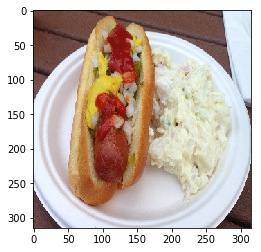

In [64]:
plt.imshow(hot_dog_img)

In [65]:
for i, p, in enumerate(probs[0]):
    print(f"{ind2label[i]} with probability {p:.4f}")

hot_dog with probability 1.0000
pulled_pork_sandwich with probability 0.0000
grilled_cheese_sandwich with probability 0.0000
lobster_roll_sandwich with probability 0.0000
hamburger with probability 0.0000
club_sandwich with probability 0.0000


## Hamburger

In [66]:
hamburger_img = read_image(PATH/"photos-315/hamburger/hamburger.jpg")

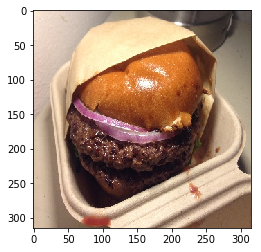

In [67]:
plt.imshow(hamburger_img)

In [68]:
for i, p, in enumerate(probs[1]):
    print(f"{ind2label[i]} with probability {p:.4f}")

hot_dog with probability 0.0000
pulled_pork_sandwich with probability 0.0001
grilled_cheese_sandwich with probability 0.0000
lobster_roll_sandwich with probability 0.0000
hamburger with probability 0.9999
club_sandwich with probability 0.0000


## Club sandwich

In [69]:
club_sandwich_img = read_image(PATH/"photos-315/club_sandwich/club_sandwich.jpg")

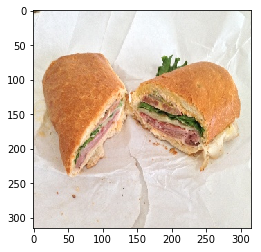

In [70]:
plt.imshow(club_sandwich_img)

In [71]:
for i, p, in enumerate(probs[2]):
    print(f"{ind2label[i]} with probability {p:.4f}")

hot_dog with probability 0.0000
pulled_pork_sandwich with probability 0.0001
grilled_cheese_sandwich with probability 0.0000
lobster_roll_sandwich with probability 0.0000
hamburger with probability 0.0001
club_sandwich with probability 0.9999
